In [2]:
import os
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [28]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E'])
plt.rcParams.update({'font.size': 14})
if not os.path.exists("figs"):
    os.makedirs("figs")

In [39]:
linear = pd.read_csv('HemoLinear/results/full.csv', index_col=0)
end2end = pd.read_csv('hemo_end2end/results/full.csv', index_col=0)

In [40]:
def get_values(df, metric, threshold):
    """
    Get the second smallest, mean, and second largest values of a metric at a given threshold.
    Args:
        df: The dataframe containing the data.
        metric: The metric to evaluate. This is the name of the column in the dataframe.
        threshold: The threshold to filter the dataframe (55 or 60)

    Returns: A tuple containing the second smallest, mean, and second largest values of the metric at the given threshold.

    """
    tmp = df[metric].loc[df['threshold'] == threshold]
    return tmp.nsmallest(2).values[1], tmp.median(), tmp.nlargest(2).values[1]

def plot_metric_comp(metric, threshold):
    """
    Plot a box plot that compares the performances of the three different approaches for a given metric at a given threshold. The maximum and minimum values are removed to reduce the noise.
    Args:
        metric: The metric to evaluate: A column in the dataframe.
        threshold: The threshold of the benchmark: 55 or 60
    Returns: the axis of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    linear_measures = get_values(linear, metric, threshold)
    end2en_measures = get_values(end2end, metric, threshold)

    categories = ['Linear', 'Hemolytic End to End']
    all_measures = [linear_measures, end2en_measures]

    box_width = 0.6
    x_positions = np.arange(len(categories))

    for i, (min_val, mean_val, max_val) in enumerate(all_measures):
        x = x_positions[i]


        # Optional: add a small rectangle around the mean
        rect_height = (max_val - min_val)
        rect = Rectangle((x - box_width/2, min_val),
                         box_width, rect_height, edgecolor='k')
        ax.add_patch(rect)

        ax.plot([x - box_width/2, x + box_width/2], [mean_val, mean_val],
                'k-', linewidth=1)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories)
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(min(min_ for min_, _, _ in all_measures) - 0.1,
               max(max_ for _, _, max_ in all_measures) + 0.1)
    ax.set_xlim(0 - box_width, len(categories) - 1 + box_width)

    plt.tight_layout()
    return fig, ax

def plot_all_metrics(metrics, threshold, alias: list[str] = None):
    """
    Plot the performances of the three different approaches for all metrics at a given threshold. The maximum and minimum values are removed to reduce the noise.
    Args:
        metrics: The metrics to plot (list of column names in the dataframe).
        threshold: the threshold 55 or 60
    Returns: The figure and axis of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min = float('inf')
    y_max = float('-inf')
    for offset, metric in enumerate(metrics):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        linear_measures = get_values(linear, metric, threshold)
        end2end_measures = get_values(end2end, metric, threshold)

        categories = ['Linear', 'Hemolytic End to End']
        all_measures = [linear_measures, end2end_measures]

        box_width = 0.25
        gap = (1 - len(categories) * box_width) / 2
        x_positions = gap + box_width * (1 + 2 * np.arange(len(categories))) / 2 + offset
        for i, (min_val, mean_val, max_val) in enumerate(all_measures):
            x = x_positions[i]


            # Optional: add a small rectangle around the mean
            rect_height = (max_val - min_val)
            rect = Rectangle((x - box_width/2, min_val),
                             box_width, rect_height, edgecolor='k', facecolor=colors[i],
                             label=categories[i] if offset == 0 else "")
            ax.add_patch(rect)

            ax.plot([x - box_width/2, x + box_width/2], [mean_val, mean_val],
                    'k-', linewidth=1)

        if min(min_ for min_, _, _ in all_measures) < y_min:
            y_min = min(min_ for min_, _, _ in all_measures)
        if max(max_ for _, _, max_ in all_measures) > y_max:
            y_max = max(max_ for _, _, max_ in all_measures)

    ax.set_xticks([i + 0.5 for i in range(len(metrics))])
    ax.set_xticklabels(alias or metrics)
    ax.set_ylabel('value')
    # ax.set_title(f'Metrics Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_min - 0.02,
               y_max + 0.02)
    ax.set_xlim(0, len(metrics))

    plt.tight_layout()
    return fig, ax

## Metrics Comparison

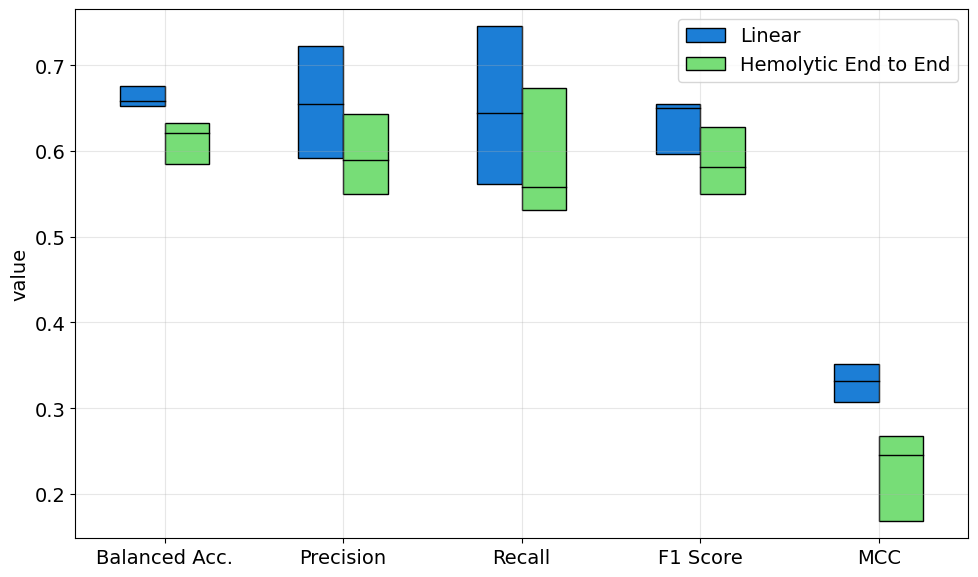

In [41]:
plot_all_metrics(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 55, ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_metrics_comparison_55.svg")

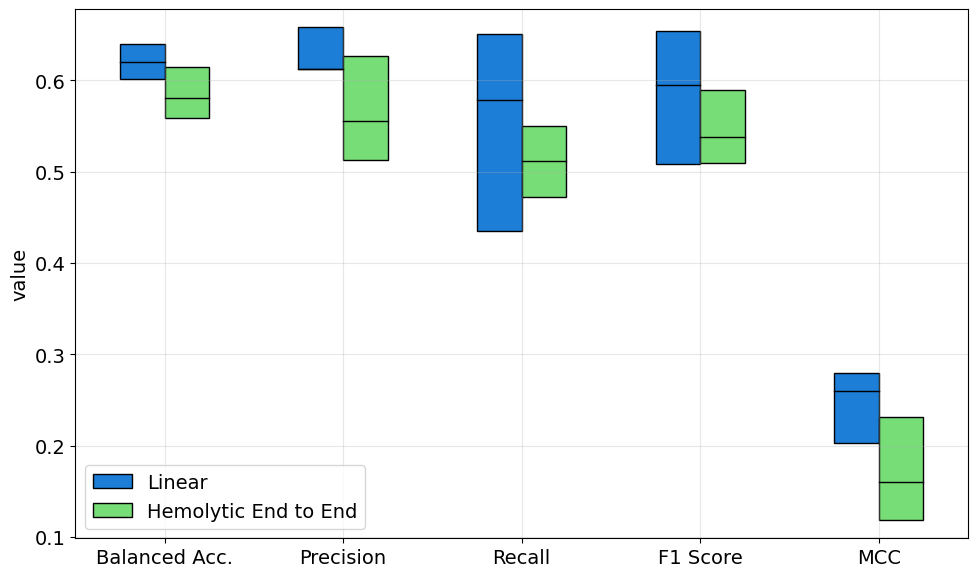

In [42]:
plot_all_metrics(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 60, ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_metrics_comparison_60.svg")

## Win ratio to determine the best approach

In [43]:
def plot_wins(metrics, threshold, direction, alias: list[str] = None):
    """
    Plot the number of wins for each model for every metric at a given threshold.
    Args:
        metrics: A list of metrics to evaluate. Each metric is a column in the dataframe.
        threshold: The threshold of the benchmark: 55 or 60
        direction: A win is counted as the maximum ('max') or minimum ('min') value of the metric.

    Returns: A matplotlib figure and axis object containing the bar plot of wins for each model.

    """
    candidates_names = ['Linear', 'Hemolytic End to End']
    wins = {candidate_name: {metric: 0 for metric in metrics} for candidate_name in candidates_names}
    for split in range(5):
        for metric in metrics:
            linear_value = linear.loc[np.logical_and(linear['split'] == split, linear['threshold'] == threshold)][metric].item()
            end2end_value = end2end.loc[np.logical_and(end2end['split'] == split, end2end['threshold'] == threshold)][metric].item()
            candidates = [linear_value, end2end_value]
            if direction == 'min':
                winner = np.argmin(candidates)
            else:
                winner = np.argmax(candidates)
            wins[candidates_names[winner]][metric] += 1

    models = list(wins.keys())
    metric_values = [[wins[model][metric] for metric in metrics] for model in models]

    # Get colors from theme
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Set up positions for bars
    n_models = len(models)
    bar_width = 0.25
    gap_between_groups = (1 - 3 * bar_width) / 2
    if gap_between_groups < 0:
        gap_between_groups = 0
        bar_width = 1 / 3
    x_positions = np.arange(len(metrics)) * (n_models * bar_width + gap_between_groups)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars with no gap between MAE and RMSE within each group
    for i, (metric_value, name) in enumerate(zip(metric_values, candidates_names)):
        rmse_bars = ax.bar(x_positions + i * bar_width, metric_value, bar_width,
                           label=name, color=colors[i])

    # Add labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Number of Wins')
    # ax.set_title('Model Performance Wins by Metric')

    # Set x-tick positions to center of each group and add model names
    ax.set_xticks(x_positions + bar_width / 2)
    ax.set_xticklabels(alias or metrics)

    # Add legend
    ax.legend()

    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    return fig, ax

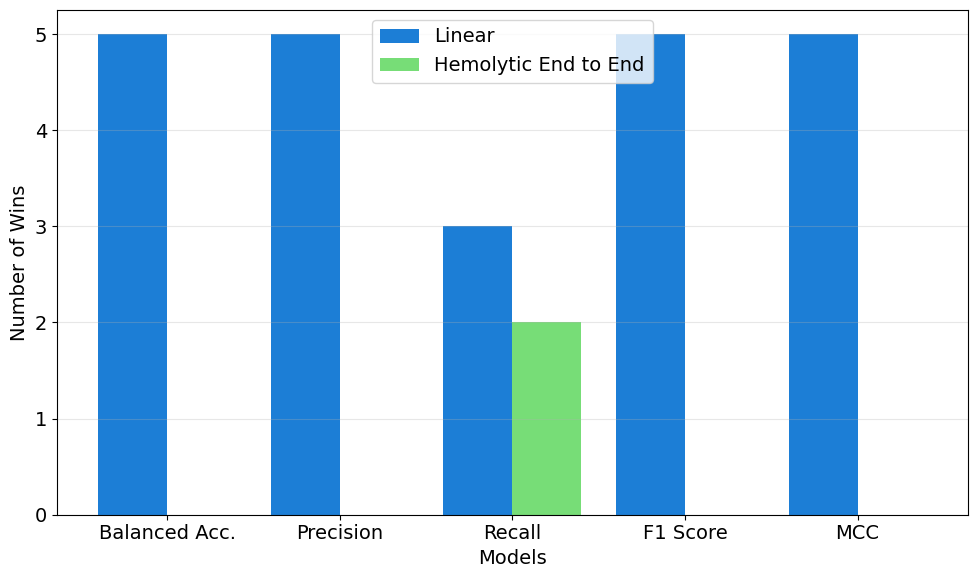

In [44]:
plot_wins(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 55, 'max', ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_wins_55.svg")

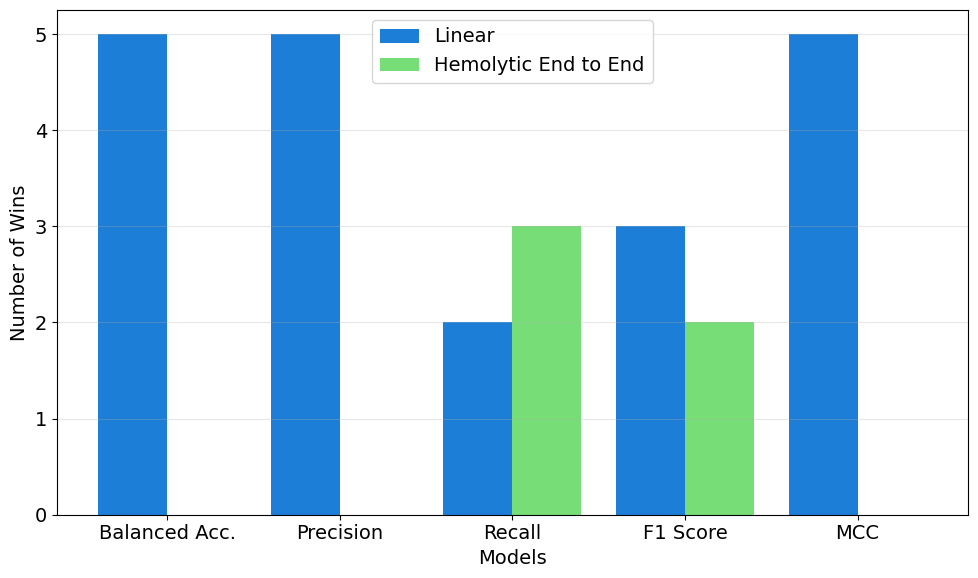

In [45]:
plot_wins(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 60, 'max', ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_wins_60.svg")

## Difference between the splits

In [36]:
def get_threshold_values(metric, model, threshold):
    """
    Get the second smallest, mean, and second largest values of a metric for a given model.
    Args:
        df: The dataframe containing the data.
        metric: The metric to evaluate. This is the name of the column in the dataframe.
        threshold: The threshold to filter the dataframe (55 or 60)
        model: The model to evaluate. This can be 'linear', 'anti_peptide', or 'regression'.

    Returns: A tuple containing the second smallest, mean, and second largest values of the metric at the given threshold.

    """
    match model:
        case 'linear':
            tmp = linear
        case 'end2end':
            tmp = end2end
        case _:
            raise ValueError(f"Unknown model: {model}")
    tmp = tmp.loc[tmp['threshold'] == threshold][metric]
    return tmp.nsmallest(2).values[1], tmp.mean(), tmp.nlargest(2).values[1]

def plot_all_metrics(metrics, model, alias: list[str] = None):
    """
    Plot the performances of the three different approaches for all metrics at a given threshold. The maximum and minimum values are removed to reduce the noise.
    Args:
        metrics: The metrics to plot (list of column names in the dataframe).
        threshold: the threshold 55 or 60
    Returns: The figure and axis of the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    y_min = float('inf')
    y_max = float('-inf')
    for offset, metric in enumerate(metrics):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        threshold_55 = get_threshold_values(metric, model, 55)
        threshold_60 = get_threshold_values(metric, model, 60)

        categories = ['55', '60']
        all_measures = [threshold_55, threshold_60]

        box_width = 0.25
        gap = (1 - len(categories) * box_width) / 2
        x_positions = gap + box_width * (1 + 2 * np.arange(len(categories))) / 2 + offset
        for i, (min_val, mean_val, max_val) in enumerate(all_measures):
            x = x_positions[i]


            # Optional: add a small rectangle around the mean
            rect_height = (max_val - min_val)
            rect = Rectangle((x - box_width/2, mean_val - rect_height/2),
                             box_width, rect_height, edgecolor='k', facecolor=colors[i],
                             label=categories[i] if offset == 0 else "")
            ax.add_patch(rect)

            ax.plot([x - box_width/2, x + box_width/2], [mean_val, mean_val],
                    'k-', linewidth=1)

        if min(min_ for min_, _, _ in all_measures) < y_min:
            y_min = min(min_ for min_, _, _ in all_measures)
        if max(max_ for _, _, max_ in all_measures) > y_max:
            y_max = max(max_ for _, _, max_ in all_measures)

    ax.set_xticks([i + 0.5 for i in range(len(metrics))])
    ax.set_xticklabels(alias or metrics)
    ax.set_ylabel('value')
    ax.set_title(f'Metrics Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_min - 0.02,
               y_max * 1.03)
    ax.set_xlim(0, len(metrics))

    plt.tight_layout()
    return fig, ax

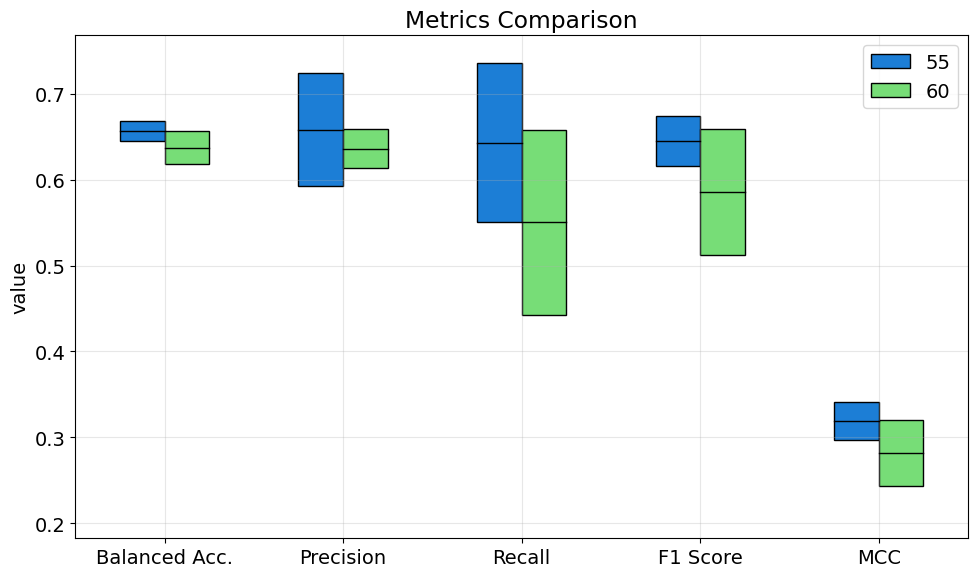

In [37]:
plot_all_metrics(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 'linear', ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_threshold_linear.svg")

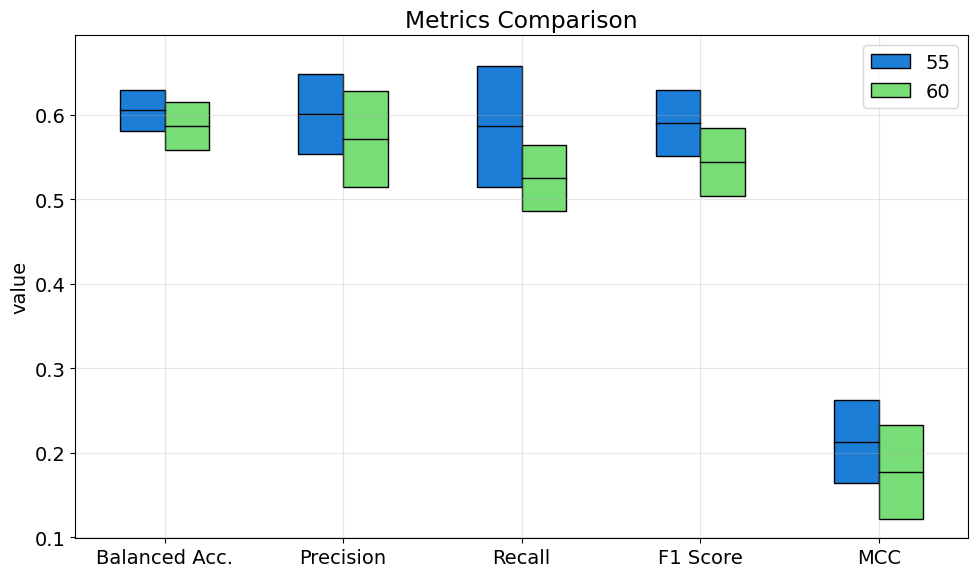

In [38]:
plot_all_metrics(["balanced_accuracy", 'precision', 'recall', 'f1', 'mcc'], 'end2end', ['Balanced Acc.', 'Precision', 'Recall', 'F1 Score', 'MCC'])
plt.savefig("figs/hemo_threshold_end2end.svg")